In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from scipy import stats
%matplotlib inline

#Problem specific libarires:
import scipy.signal as sig

(Text(0.5, 0, 'N'), Text(0, 0.5, 't'))

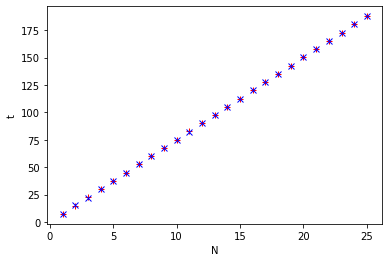

In [8]:
#Importing data-files:
data1 = np.genfromtxt('data_times_Alice_pendulum14m_25measurements.dat', delimiter='', skip_header=0, skip_footer=0, dtype=float)
data2 = np.genfromtxt('data_times_Bob_pendulum14m_25measurements.dat', delimiter='', skip_header=0, skip_footer=0, dtype=float)

N_a, t_a = data1[:, 0], data1[:, 1]
N_b, t_b = data2[:, 0], data2[:, 1]

plt.plot(N_a, t_a, 'r+')
plt.plot(N_b, t_b, 'bx')
plt.xlabel('N'), plt.ylabel('t')

In [ ]:
#Linear time-fit:
def T_func(N,T):
    return T*N
    